In [101]:
## Net, Loss Function, Optimizer

In [2]:
from __future__ import print_function
import mxnet as mx
from mxnet import nd, autograd, gluon
mx.random.seed(1)

In [3]:
data_ctx = mx.cpu()
model_ctx = mx.cpu()

In [4]:
num_inputs = 2
num_outputs = 1
num_examples = 10000

In [15]:
def real_fn(X):
    return 2*X[:,0] -3.4*X[:,1] + 4.2

In [19]:
X = nd.random.normal(shape = (num_examples, num_inputs), ctx = data_ctx)
noise = .1*nd.random.normal(shape = (num_examples,), ctx = data_ctx)
y = real_fn(X) + noise
# y is on data_ctx cuz X and noise are on data_ctx

In [18]:
print(X[0])
print(y[0])


[ 0.31053242 -0.80406934]
<NDArray 2 @cpu(0)>

[ 7.48754549]
<NDArray 1 @cpu(0)>


In [20]:
print(2*X[0,0] -3.4*X[0,1] + 4.2)


[-2.24768877]
<NDArray 1 @cpu(0)>


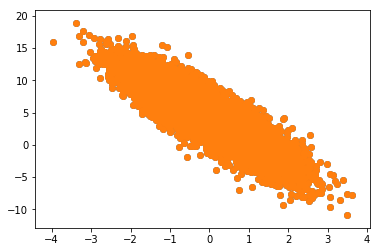

In [23]:
import matplotlib.pyplot as plt
plt.scatter(X[:,1].asnumpy(), y.asnumpy())
plt.show()

In [24]:
## Array Batch
batch_size = 4
train_data = gluon.data.DataLoader(gluon.data.ArrayDataset(X,y),
                                  batch_size=batch_size, shuffle = True)
# its like python list type

In [28]:
for i, (data, label) in enumerate(train_data):
    print(data, label)
    break


[[-1.40076029 -1.34730709]
 [-0.09338376 -0.95146823]
 [ 1.4378202  -1.65603256]
 [-1.78752017 -0.70206988]]
<NDArray 4x2 @cpu(0)> 
[  6.20856667   7.25207138  12.84613705   3.11132526]
<NDArray 4 @cpu(0)>


In [29]:
counter = 0
for i, (data, label) in enumerate(train_data):
    pass
print(i+1)

2500


In [33]:
# Model parameter
w = nd.random.normal(shape = (num_inputs, num_outputs), ctx = model_ctx)
b = nd.random.normal(shape =num_outputs, ctx = model_ctx)
params = [w,b]

In [37]:
# allocate some memory for each gradient
for param in params:
    param.attach_grad()

In [38]:
# Neural Nets
def net(X):
    return mx.nd.dot(X,w) + b

In [39]:
# Loss Function
def square_loss(yhat, y):
    return nd.mean((yhat - y)**2)

In [40]:
# Optimizer
def SGD(params, lr):
    for param in params:
        param[:] = param - lr*param.grad

In [41]:
# Execute training loop
epochs = 10
lr = 0.0001
num_batches = num_examples/batch_size

In [43]:
for e in range(epochs):
    cum_loss = 0
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(model_ctx)
        label = label.as_in_context(model_ctx).reshape((-1,1))
        with autograd.record():
            output = net(data)
            loss = square_loss(output, label)
        loss.backward()
        SGD(params, lr)
        cum_loss += loss.asscalar()
        print(loss)
    print(cum_loss/num_batches)

26.3493830349
9.85866044166
3.69294822788
1.38723590357
0.524983645925
0.202567355324
0.081970860434
0.0368648497789
0.0200016844932
0.0136910333379


In [49]:
############################################
#    Re-initialize parameters because they
#    were already trained in the first loop
############################################
w[:] = nd.random_normal(shape=(num_inputs, num_outputs), ctx=model_ctx)
b[:] = nd.random_normal(shape=num_outputs, ctx=model_ctx)

In [50]:
############################################
#    Script to plot the losses over time
############################################
def plot(losses, X, sample_size=100):
    xs = list(range(len(losses)))
    f, (fg1, fg2) = plt.subplots(1, 2)
    fg1.set_title('Loss during training')
    fg1.plot(xs, losses, '-r')
    fg2.set_title('Estimated vs real function')
    fg2.plot(X[:sample_size, 1].asnumpy(),
             net(X[:sample_size, :]).asnumpy(), 'or', label='Estimated')
    fg2.plot(X[:sample_size, 1].asnumpy(),
             real_fn(X[:sample_size, :]).asnumpy(), '*g', label='Real')
    fg2.legend()

    plt.show()

Epoch 0, batch 2499. Mean loss: 16.9518271783
Epoch 1, batch 2499. Mean loss: 6.34111349337
Epoch 2, batch 2499. Mean loss: 2.37612864648
Epoch 3, batch 2499. Mean loss: 0.894377977879
Epoch 4, batch 2499. Mean loss: 0.340528121065
Epoch 5, batch 2499. Mean loss: 0.133540610675
Epoch 6, batch 2499. Mean loss: 0.0561298388162
Epoch 7, batch 2499. Mean loss: 0.027200881307
Epoch 8, batch 2499. Mean loss: 0.0163887562737
Epoch 9, batch 2499. Mean loss: 0.01234609175


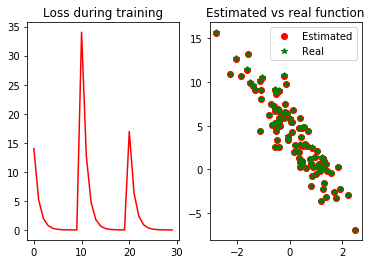

In [51]:
for e in range(epochs):
    cumulative_loss = 0
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(model_ctx)
        label = label.as_in_context(model_ctx).reshape((-1, 1))
        with autograd.record():
            output = net(data)
            loss = square_loss(output, label)
        loss.backward()
        SGD(params, learning_rate)
        cumulative_loss += loss.asscalar()

    print("Epoch %s, batch %s. Mean loss: %s" % (e, i, cumulative_loss/num_batches))
    losses.append(cumulative_loss/num_batches)

plot(losses, X)

### With Gluon

In [82]:
net = gluon.nn.Dense(1, in_units=2)

In [83]:
print(net.weight.shape)
print(net.bias.shape)
print(type(net.weight))

(1, 2)
(1,)
<class 'mxnet.gluon.parameter.Parameter'>


In [84]:
# Gluon block : block is the just units that take inputs and generates outputs, also contin parameters we can update

In [85]:
type(net.collect_params())

mxnet.gluon.parameter.ParameterDict

In [86]:
# parameter initialization
net.collect_params().initialize(mx.init.Normal(sigma=1.), ctx = model_ctx)
## initialization is deffered until first forward pass is done

In [90]:
ex_data = nd.array([[4,7]])
net(ex_data)


[[-10.73987865]]
<NDArray 1x1 @cpu(0)>

In [93]:
print(net.weight.data())
print(net.bias.data())


[[-0.23999484 -1.39712846]]
<NDArray 1x2 @cpu(0)>

[ 0.]
<NDArray 1 @cpu(0)>


In [94]:
del net

In [98]:
# net declaration without in_units
net = gluon.nn.Dense(1)
net.collect_params().initialize(mx.init.Normal(sigma=1.), ctx = model_ctx)

In [105]:
## define loss
square_loss = gluon.loss.L2Loss()

In [106]:
## Optimizer
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate':0.0001})

In [107]:
epochs =10
loss_sequene = []
num_batches = num_examples / batch_size

In [110]:
for e in range(epochs):
    cum_loss = 0
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(model_ctx)
        label = label.as_in_context(model_ctx)
        
        # calculate derivatives against loss
        with autograd.record():
            output = net(data)
            loss = square_loss(output, label)
        loss.backward()
        
        # update weight (one step parameter update)
        trainer.step(batch_size)
        cum_loss += nd.mean(loss).asscalar()
    print("Epoch %s, loss: %s" % (e, cum_loss/num_examples))
    loss_sequene.append(cum_loss)

Epoch 0, loss: 0.74395205415
Epoch 1, loss: 0.455864119995
Epoch 2, loss: 0.27951763631
Epoch 3, loss: 0.171572987754
Epoch 4, loss: 0.105502302418
Epoch 5, loss: 0.0650608475657
Epoch 6, loss: 0.0403084642644
Epoch 7, loss: 0.0251567380209
Epoch 8, loss: 0.0158811236915
Epoch 9, loss: 0.0102031620487


In [112]:
loss_sequene

[41047.002575591207,
 25129.293973267078,
 15386.242321163416,
 7439.5205415040255,
 4558.6411999491975,
 2795.1763631002977,
 1715.729877541773,
 1055.0230241841637,
 650.60847565671429,
 403.08464264392387,
 251.56738020910416,
 158.81123691468383,
 102.03162048687227]

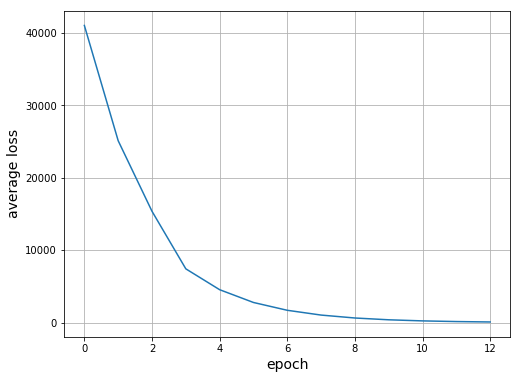

In [113]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

plt.figure(num=None,figsize=(8, 6))
plt.plot(loss_sequene)

# Adding some bells and whistles to the plot
plt.grid(True, which="both")
plt.xlabel('epoch',fontsize=14)
plt.ylabel('average loss',fontsize=14)

In [114]:
params = net.collect_params()

In [116]:
print('The type of "params" is a ',type(params))

The type of "params" is a  <class 'mxnet.gluon.parameter.ParameterDict'>


In [117]:
for param in params.values():
    print(param.name,param.data())

dense7_weight 
[[ 1.92711401 -3.23252106]]
<NDArray 1x2 @cpu(0)>
dense7_bias 
[ 4.04894066]
<NDArray 1 @cpu(0)>
